In [722]:
from __future__ import print_function, division
%matplotlib inline

# import used packages and modules
# import display function to display the table of the pandas dataframe
from IPython.display import display

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelSpreading

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.exceptions import NotFittedError

from scipy import signal

from hmmlearn import hmm
from seqlearn.hmm import MultinomialHMM

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv


import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization

# Importing Data

In [645]:
train_manchester = pd.read_csv('../data/misc/Train_Manchester_Northwich.csv')
london_data = pd.read_csv('../data/london_data/london_data.csv')

data04 = pd.read_csv('../data/meadows_december/meadows-2017-12-04.csv')
data05 = pd.read_csv('../data/meadows_december/meadows-2017-12-05.csv')
data06 = pd.read_csv('../data/meadows_december/meadows-2017-12-06.csv')
data07 = pd.read_csv('../data/meadows_december/meadows-2017-12-07.csv')

bike_data_old = pd.read_csv('../data/misc/2015061911.csv')
bike_data_old2 = pd.read_csv('../data/misc/2015061817.csv')
bike_data_old3 = pd.read_csv('../data/misc/20150618.csv')
bike_data_feb = pd.read_csv('../data/misc/bike_feb.csv')

walk_data_vlad1 = pd.read_csv('../data/validation/015Outdoor-Day-2018-02-28.csv')
walk_data_vlad2 = pd.read_csv('../data/validation/016Outdoor-Night-2018-02-28.csv')

bus_data = pd.read_csv('../data/validation/queensferry-13-03-2018.csv')

# Merging Data

In [646]:
bin_vals = ['bin'+str(x) for x in range(0,16)]
norm_bin_vals = ['bin_norm'+str(x) for x in range(0,16)]
pm_vals = ['pm1', 'pm2_5', 'pm10']

In [647]:
# environment index is 0 as all data from these datasets is walking data
data04['environment_index'] = 0
data05['environment_index'] = 0
data06['environment_index'] = 0
data07['environment_index'] = 0

walk_data_vlad1['environment_index'] = 0
walk_data_vlad2['environment_index'] = 0

# environment index is 3 for bike data
bike_data_old['environment_index'] = 3
bike_data_old2['environment_index'] = 3
bike_data_old3['environment_index'] = 3
bike_data_feb['environment_index'] = 3

# rename columns
bike_data_old2 = bike_data_old2.rename(
    index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude'})
bike_data_old3 = bike_data_old3.rename(
    index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude'})

labels = bin_vals + pm_vals + ['environment_index', 'gpsLatitude', 'gpsLongitude', 'humidity', 'temperature']

bus_data_bus = bus_data[bus_data['environment_index']==4].copy()

data = pd.concat([london_data[labels],
                  train_manchester[labels], 
                  data04[labels], 
                  data05[labels],
                  data06[labels],
                  data07[labels],
                  bus_data_bus[labels],
                  walk_data_vlad1[labels],
                  walk_data_vlad2[labels],
                  bike_data_old2[labels],
                  bike_data_feb[labels]], ignore_index=True)

# remove indoor labelled data for this set of experiments
data = data[data['environment_index']!=7]
data = data[data['environment_index']!=5]
data = data[data['humidity']>0]
data = data[data['temperature']>0]
data['total'] = data[bin_vals].apply(lambda row: np.sum(row), axis=1)
data = data[data['total']>0]

### Data Information

In [648]:
data.describe()

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin15,pm1,pm2_5,pm10,environment_index,gpsLatitude,gpsLongitude,humidity,temperature,total
count,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,...,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000,4828.000000
mean,418.498964,106.039975,63.724731,37.454432,14.229287,13.807995,8.619097,3.970795,4.381317,2.953190,...,7.269677,5.223990,10.129931,21.263915,2.124068,55.408412,-2.746921,53.070101,18.146119,726.158451
std,852.884266,221.041963,126.755927,67.158065,24.856277,23.472983,25.123332,51.045978,145.152936,137.027311,...,343.949408,8.472036,11.594826,49.795412,1.598547,1.288173,0.978898,10.173585,7.514731,2964.395810
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,51.493892,-3.397216,17.600000,0.100000,1.000000
25%,39.000000,15.000000,10.000000,6.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.570195,4.503510,6.535241,0.000000,55.939869,-3.200267,46.299999,14.375001,107.000000
50%,189.000000,69.000000,42.000000,24.000000,9.000000,9.000000,5.000000,1.000000,0.000000,0.000000,...,0.000000,3.054183,7.568033,11.285377,3.000000,55.944698,-3.189287,53.093822,18.000000,404.000000
75%,471.250000,113.000000,73.000000,44.000000,17.000000,18.000000,11.000000,3.000000,1.000000,1.000000,...,0.000000,6.687421,12.163227,20.333473,3.000000,55.950874,-3.181609,57.300000,22.825001,749.250000
max,12336.000000,4758.000000,3710.000000,1997.000000,538.000000,434.000000,656.000000,3343.000000,7955.000000,9500.000000,...,16999.000000,108.471610,158.405240,1051.750977,6.000000,56.008247,-0.100202,99.800000,110.700005,152492.000000


### Labels

In [649]:
labels_idx = np.array([0, 1, 2, 3, 4, 6])

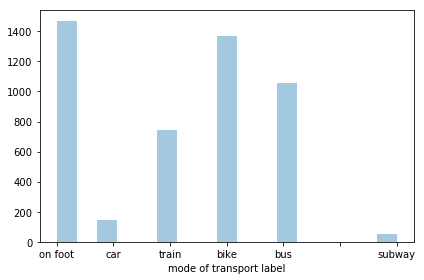

In [650]:
hist = plt.figure()
g = sns.distplot(data['environment_index'], kde=False)
g.set_xticklabels(['', 'on foot', 'car', 'train', 'bike', 'bus', '', 'subway'])
plt.xlabel('mode of transport label')
plt.tight_layout()
hist.savefig('../report/distribution.pdf')
plt.show()

# Kmeans

In [651]:
# method to get the cluster means of the data points based on coordinates
# and the queried columns
def get_location_cluster_means(data, cluster_no, cols):
    # obtain indices of clusters
    kmeans = KMeans(n_clusters=cluster_no, random_state=0)
    # remove data rows with null coordinates
    data = data[~np.isnan(data['gpsLatitude'])]
    # get the indices of the location based clusters
    indices = kmeans.fit_predict(data[['gpsLatitude', 'gpsLongitude']])
    freqs = np.bincount(indices)
    # initialise means of queried columns
    means = np.zeros((cluster_no, len(cols)))
    # assign clustered_indices to dataframe
    data['clustered_index'] = indices
    # compute means of queried columns
    for index in np.unique(indices):
        means[index] = np.mean(data[data['clustered_index'] == index][cols])
    return means, data

In [652]:
# method to get the clusters of the environments corresponding to the 6 environments based on
# the queried columns and number of location clusters
def get_environment_clusters(data, cluster_no, cols, kmeans=None):
    means, d = get_location_cluster_means(data, cluster_no, cols)
    # we have 6 clusters corresponding to 6 different types of environment
    if not kmeans:
        environment_kmeans = KMeans(n_clusters=6, random_state=0)
        environment_indices = environment_kmeans.fit_predict(means)
    else:
        try:
            environment_kmeans = kmeans
            environment_indices = environment_kmeans.predict(means)
        except NotFittedError:
            environment_indices = environment_kmeans.fit_predict(means)
    # predict the cluster indices
    # sort the indices based on the means of the clusters
    idx = np.argsort(environment_kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(6)
    # append the indices to the dataframe
    d['unsupervised_environment_index'] = lut[environment_indices][d['clustered_index']]
    return d

# Stats Methods

In [653]:
def plot_confusion_matrix(labels, predictions, title='Confusion matrix', 
                          classes=['on_foot', 'car', 'train', 'bike', 'bus', 'underground']):
    """Plots a confusion matrix."""
    cmatrix = np.array(confusion_matrix(labels, predictions))
    # normalize confusion matrix
    cm = cmatrix/cmatrix.sum(axis=1)[:, np.newaxis]
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True data')
    plt.xlabel('Predicted data')
    plt.show()

In [654]:
def get_training_accuracy_with_kfolds_iloc(estimator, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        estimator.fit(x_tr.iloc[train_feature], y_tr.iloc[train_feature])
        y_pred = estimator.predict(x_tr.iloc[test_feature])
        cm = confusion_matrix(y_tr.iloc[test_feature], y_pred)
        cm_norm = cm.astype('float')/cm.sum(axis=1)
        score_array[idx] = accuracy_score(y_tr.iloc[test_feature], y_pred, normalize=True)
        
#         plot_confusion_matrix(y_tr.iloc[test_feature], y_pred)
        
    return np.mean(score_array)

In [655]:
def get_training_accuracy_mixed_models(estimator, attributes_list, x_tr, y_tr, x_ts, y_ts):
    
    probs_array = np.empty((len(attributes_list), x_ts.shape[0], 6))

    for estimator_idx, attrs in enumerate(attributes_list):
        estimator.fit(x_tr[attrs], y_tr)
        probs_array[estimator_idx] = estimator.predict_proba(x_ts[attrs])

    final_labels = labels_idx[np.argmax(np.mean(probs_array, axis=0), axis=1)]
    score = accuracy_score(y_ts, final_labels, normalize=True)
    
    return score

In [656]:
def get_training_accuracy_mixed_models_kfolds(estimator, attributes, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        estimator.fit(x_tr.iloc[train_feature], y_tr.iloc[train_feature])
        y_pred = estimator.predict(x_tr.iloc[test_feature])
        
        score_array[idx] = get_training_accuracy_mixed_models(
            estimator, attributes, x_tr.iloc[train_feature], y_tr.iloc[train_feature],
            x_tr.iloc[test_feature], y_tr.iloc[test_feature]
        )
                
    return np.mean(score_array)

# Absolute Values

### Bin Values

In [657]:
svc = SVC()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.5787107778457181


In [658]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.8889805726300433


In [748]:
et = ExtraTreesClassifier(n_jobs=-1, random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(et, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.8854602602473746


In [659]:
lr = LogisticRegressionCV(n_jobs=-1)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7810688808075608


In [660]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.8732400047200679


In [661]:
clf = MLPClassifier()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7978534418948927


### First 3 Bin Counts

In [662]:
svc = SVC()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.5816108304101095


In [663]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.8237382936954912


In [664]:
lr = LogisticRegressionCV(n_jobs=-1)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.6888977568950535


In [665]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.8299514047565412


In [666]:
clf = MLPClassifier()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.6783417543633808


### PM Values

In [667]:
svc = SVC()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7897756895053584


In [668]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.8123474828092985


In [669]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7920477585041676


In [670]:
lr = LogisticRegressionCV(n_jobs=-1)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7063068687713878


In [671]:
clf = MLPClassifier()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7442098713781525


### Urban Environments

In [672]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

rf = RandomForestClassifier(random_state=0, n_jobs=-1)
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.9264718565957584


In [749]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

rf = ExtraTreesClassifier(random_state=0, n_jobs=-1)
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.9227432175843981


In [673]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

svc = SVC()
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.5795391497441509


In [674]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

lr = LogisticRegressionCV(n_jobs=-1)
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.8183529108872655


In [675]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

knn = KNeighborsClassifier()
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.8736542979435523


In [676]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clf = MLPClassifier()
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.7918432937491284


### Normalised Bin Counts

In [677]:
data_normalised = data[data['total']>0].copy().reindex()
data_normalised[bin_vals] = data_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
data_normalised['pca_pm'] = PCA(n_components=1).fit_transform(data_normalised[pm_vals])

In [704]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data_normalised[bin_vals+['total']], 
                                                          data_normalised['environment_index'], kf))

Accuracy: 0.8958156598976604


In [705]:
svc = SVC()
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data_normalised[bin_vals+['total']], 
                                                          data_normalised['environment_index'], kf))

Accuracy: 0.7359188577435931


In [706]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data_normalised[bin_vals+['total']], 
                                                          data_normalised['environment_index'], kf))

Accuracy: 0.7495849558566388


In [707]:
clf = MLPClassifier()
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data_normalised[bin_vals+['total']], 
                                                          data_normalised['environment_index'], kf))

Accuracy: 0.45296581169074973


# Best Models

In [757]:
clustered_data = get_environment_clusters(data, 25, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

rf = RandomForestClassifier(random_state=0, n_estimators=150, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_normalised_data[['unsupervised_environment_index', 'total']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

print("Feature Importance:", rf.feature_importances_)

Accuracy: 0.9415898046535578
Feature Importance: [0.11516881 0.32302764 0.07167486 0.0380017  0.04233454 0.07126235
 0.04587171 0.07927884 0.07190401 0.06721153 0.03548666 0.01221274
 0.0068393  0.00539837 0.00413415 0.00417684 0.00235959 0.00365635]


## Add temperature and humidity

In [759]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

rf = RandomForestClassifier(random_state=0, n_estimators=260, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_normalised_data[['unsupervised_environment_index', 'temperature', 'humidity', 'total']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

print("Feature Importance:", rf.feature_importances_)

Accuracy: 0.9616790568446346
Feature Importance: [0.08745388 0.15693474 0.0753805  0.24678492 0.06284658 0.0246449
 0.03056922 0.06286498 0.03792062 0.05087913 0.0454505  0.06292435
 0.02607699 0.00931245 0.00544731 0.0042332  0.003024   0.00301234
 0.00147651 0.00276288]


In [710]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

knn = KNeighborsClassifier()
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, clustered_normalised_data[['unsupervised_environment_index', 'total']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.7636707109065748


### Neural Network

In [685]:
# environment clustering on raw bin values: 3 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(20,), 
                    random_state=1, 
                    max_iter=500)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.7901852626610455


### KNN

In [686]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.8119306150033792


### Mixed Model

In [823]:
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

get_training_accuracy_mixed_models_kfolds(rf, 
                                          [
                                              ['unsupervised_environment_index', 'total']+bin_vals,
                                              ['humidity', 'temperature'],
                                          ], 
                                          clustered_normalised_data,
                                          clustered_normalised_data['environment_index'], kf)

0.9830161233224987

### Validating Models

#### Train Data

In [815]:
kmeans = KMeans(n_clusters=6, random_state=0)
clustered_train = get_environment_clusters(data, 40, bin_vals, kmeans).reindex()
clustered_normalised_train = clustered_train[clustered_train['total']>0].copy().reindex()
clustered_normalised_train[bin_vals] = clustered_normalised_train[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

#### Bike validation data

In [816]:
bike_data_validation = pd.read_csv('../data/misc/2015072817.csv')
bike_data_validation['environment_index'] = 3
bike_data_validation['total'] = bike_data_validation[bin_vals].apply(lambda row: np.sum(row), axis=1)

bike_data_validation = bike_data_validation.rename(index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude'})
display(bike_data_validation.describe())

,time,gpsLatitude,gpsLongitude,bin0,bin1,bin2,bin3,bin4,bin5,bin6,...,temperature,humidity,alphaVersion,urban_space,o3_ae,o3_we,no2_ae,no2_we,environment_index,total
count,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.0,250.0,250.000000,250.000000,250.000000,250.000000,250.0,250.000000
mean,2.015073e+13,55.946380,-3.189356,3.016000,0.344000,0.220000,0.168000,0.136000,0.240000,0.188000,...,23.601040,49.532016,2.0,0.0,-25647.920000,-25242.416000,-27040.560000,-26069.808000,3.0,4.628000
std,1.221088e+02,0.000037,0.000111,1.838823,0.575316,0.452126,0.405504,0.354976,0.528695,0.421148,...,0.606837,4.011418,0.0,0.0,6289.142903,3210.032059,5074.136107,3632.280436,0.0,2.217495
min,2.015073e+13,55.946215,-3.189550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,21.960000,44.655179,2.0,0.0,-32222.000000,-31198.000000,-32734.000000,-32478.000000,3.0,0.000000
25%,2.015073e+13,55.946380,-3.189470,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.342500,45.051665,2.0,0.0,-28638.000000,-27358.000000,-29918.000000,-28638.000000,3.0,3.000000
50%,2.015073e+13,55.946398,-3.189300,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.755000,49.939463,2.0,0.0,-26846.000000,-25822.000000,-27742.000000,-26334.000000,3.0,4.000000
75%,2.015073e+13,55.946398,-3.189300,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.067500,51.480962,2.0,0.0,-25054.000000,-24286.000000,-25310.000000,-24542.000000,3.0,6.000000
max,2.015073e+13,55.946398,-3.189151,10.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000,...,24.180000,58.565045,2.0,0.0,32546.000000,-13534.000000,32034.000000,-11742.000000,3.0,12.000000


In [817]:
clustered_validation_data = get_environment_clusters(bike_data_validation, 40, bin_vals, kmeans)

clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals+['total','unsupervised_environment_index'], ['temperature', 'humidity']],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                        ))

# rf.fit(clustered_normalised_train[bin_vals+['unsupervised_environment_index', 'total']], 
#        clustered_normalised_train['environment_index'])

# predictions = rf.predict(clustered_normalised[bin_vals+['unsupervised_environment_index', 'total']])

# print("Validation accuracy:", accuracy_score(clustered_normalised['environment_index'], predictions))
 

0.9878048780487805


In [818]:
clustered_validation_data = get_environment_clusters(bike_data_validation, 40, bin_vals, kmeans)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals+['total','unsupervised_environment_index'], ['humidity']],
                                         clustered_train, clustered_train['environment_index'],
                                         clustered_validation_data, clustered_validation_data['environment_index'],
                                        ))

# rf.fit(clustered_train[bin_vals + ['unsupervised_environment_index', 'total']], 
#        clustered_train['environment_index'])

# predictions = rf.predict(clustered_validation_data[bin_vals + ['unsupervised_environment_index', 'total']])

# print("Validation accuracy:", accuracy_score(clustered_validation_data['environment_index'], predictions))
 

1.0


### Walking Validation Data

In [692]:

walk_data_validation_total = pd.read_csv('../data/validation/024Outdoor-Day-2018-03-05.csv')

walk_data_validation_total['environment_index'] = 0

display(walk_data_validation_total.describe())

,phoneTimestamp,pm1,pm2_5,pm10,temperature,humidity,bin0,bin1,bin2,bin3,...,bin14,bin15,total,gpsLongitude,gpsLatitude,gpsAltitude,gpsAccuracy,luxLevel,motion,environment_index
count,2.860000e+02,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,...,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.0
mean,1.520262e+12,10.094618,12.424445,17.979335,6.921679,64.987413,539.772727,101.111888,40.804196,17.562937,...,0.017483,0.024476,720.342657,-3.187221,55.951014,127.997114,10.024007,31.576923,3246.398601,0.0
std,2.287221e+06,7.186586,8.985549,11.127342,3.367724,20.525194,330.817500,106.139141,50.443404,21.009803,...,0.131290,0.154791,493.213247,0.001629,0.003453,14.690534,0.193646,18.184996,741.746731,0.0
min,1.520260e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-3.191518,55.944679,71.707644,10.000000,4.000000,39.000000,0.0
25%,1.520260e+12,6.068395,7.532011,10.323843,5.600000,63.100002,326.000000,57.000000,23.000000,10.000000,...,0.000000,0.000000,432.000000,-3.188255,55.947735,120.419377,10.000000,19.000000,2887.000000,0.0
50%,1.520261e+12,7.997307,9.873313,16.104126,6.000000,73.700005,409.000000,76.000000,30.000000,14.000000,...,0.000000,0.000000,556.500000,-3.187173,55.951773,128.613202,10.000000,29.000000,3269.500000,0.0
75%,1.520265e+12,12.648389,15.113871,23.184410,7.700000,76.350001,699.000000,115.000000,47.000000,20.000000,...,0.000000,0.000000,912.500000,-3.186362,55.953629,137.060204,10.000000,39.000000,3559.000000,0.0
max,1.520266e+12,78.974530,103.687230,113.550224,18.100000,84.600000,2995.000000,1311.000000,638.000000,286.000000,...,1.000000,1.000000,5372.000000,-3.183764,55.956490,154.825047,12.883000,111.000000,8304.000000,0.0


In [807]:
clustered_validation_data = get_environment_clusters(walk_data_validation_total, 40, bin_vals, kmeans)

clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

# rf.fit(clustered_normalised_train[bin_vals+['unsupervised_environment_index', 'temperature', 'humidity', 'total']], 
#        clustered_normalised_train['environment_index'])

# predictions = rf.predict(clustered_normalised[bin_vals+['unsupervised_environment_index', 'temperature', 'humidity', 'total']])
print(get_training_accuracy_mixed_models(rf, [
    bin_vals+['total','unsupervised_environment_index'], ['temperature', 'humidity']],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                        ))


0.9752650176678446


In [806]:
clustered_validation_data = get_environment_clusters(walk_data_validation_total, 40, bin_vals, kmeans)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals+['total','unsupervised_environment_index'], ['temperature', 'humidity']],
                                         clustered_train, clustered_train['environment_index'],
                                         clustered_validation_data, clustered_validation_data['environment_index'],
                                        ))
 

0.958041958041958


### Bus Validation Data

In [695]:
bus_data_val = pd.read_csv('../data/validation/queensferry-13-03-2018.csv')
bus_data_val = bus_data_val[bus_data_val['environment_index']!=7]

In [821]:
clustered_validation_data = get_environment_clusters(bus_data_val, 40, bin_vals, kmeans)
clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals+['total','unsupervised_environment_index'], ['temperature','humidity']],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                        ))



0.9347202295552367


In [822]:
clustered_validation_data = get_environment_clusters(bus_data, 40, bin_vals, kmeans)

print(get_training_accuracy_mixed_models(rf, [
    ['temperature','humidity'], 
    bin_vals+['total','unsupervised_environment_index']
],
                                         clustered_train, clustered_train['environment_index'],
                                         clustered_validation_data, clustered_validation_data['environment_index'],
                                        ))



0.8897260273972603
